In [6]:
# Importing all the necessary libraries
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, EarlyStoppingCallback
from datasets import load_dataset, Dataset
from torch.utils.data import DataLoader
from peft import get_peft_model, LoraConfig, TaskType
from sklearn.metrics import accuracy_score, f1_score, precision_score
import numpy as np
import pandas as pd
import pickle
import os

In [7]:
# Setting seed values for reproducibility
seed = 42
trainer_seed = 42
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
# some cudnn methods can be random even after fixing the seed
# unless you tell it to be deterministic
torch.backends.cudnn.deterministic = True

In [8]:
# Defining variables, parameters and configs for the run

run_on_kaggle = 1                                        # Set this to 1 if running on Kaggle, 0 if running on local machine

# Setting up the directories and test data paths
if run_on_kaggle:
    test_data_path = "./data/test_unlabelled.pkl"
else:
    test_data_path = "/kaggle/input/deep-learning-spring-2025-project-2/test_unlabelled.pkl"

# Defining LoRA configurations and other paths for the model
config = dict()

# Model configurations
config['model_name'] = "roberta-base"                          # Base model name
config['num_labels'] = 4                                       # Number of labels for the classification task

# Tokenizer Configuration for the run
config['dataset_name'] = 'ag_news'                              # Dataset name for the run
config['tokenizer_model_name'] = "roberta-base"                # Tokenizer model name
config['truncation'] = True                                    # Truncate the input sequences to the maximum length
config['padding'] = "max_length"                               # Pad the input sequences to the maximum length
config['max_length'] = 128                                     # Maximum length of the input sequences

# LoRA Configuration for the run
config['lora_rank'] = 4                                        # Rank of the LoRA layers
config['lora_alpha'] = 8                                       # Alpha value for the LoRA layers
config['lora_dropout'] = 0.6                                   # Dropout rate for the LoRA layers
config['target_modules'] = ['query', 'value']                  # Target modules for the LoRA layers
config['lora_bias'] = "none"                                   # Bias configuration for the LoRA layers
config['task_type'] = TaskType.SEQ_CLS                         # Task type for the LoRA layers
config['use_dora'] = True                                      # Use DORA (Dynamic LoRA) for the model
config['use_rslora'] = True                                    # Use RSLORA (Recurrent LoRA) for the model
config['lora_init_weights'] = "gaussian"                       # Initialization weights for the LoRA layers
config['lora_rank_pattern'] = {}                               # Dictionary to store the rank pattern for LoRA layers. This was used to assign a higher rank for the higher layers
config['lora_alpha_pattern'] = {}                              # Dictionary to store the alpha pattern for LoRA layers. This was used to assign a higher alpha for the higher layers

# Training Hyperparameters and configurations for the run
config['output_dir'] = './model/best-model'                    # Directory to save the model checkpoints
config['eval_strategy'] = "epoch"                              # Evaluation strategy for the training
config['save_strategy'] = "epoch"                              # Save strategy for the training
config['learning_rate'] = 2e-4                                 # Learning rate for the training
config['train_batch_size'] = 32                                # Batch size for training
config['eval_batch_size'] = 64                                 # Batch size for evaluation
config['num_train_epochs'] = 10                                # Number of training epochs
config['weight_decay'] = 0.1                                   # Weight decay for the optimizer
config['warmup_ratio'] = 0.1                                   # Warmup ratio (percentage of total steps) for the learning rate scheduler
config['lr_scheduler_type'] = "cosine"                         # Learning rate scheduler type
config['load_best_model_at_end'] = True                        # Load the best model at the end of training
config['metric_for_best_model'] = "eval_loss"                  # Metric to use for selecting the best model
config['greater_is_better'] = False                            # Whether a higher value of the metric is better or not
config['label_smoothing_factor'] = 0.0                         # Label smoothing factor for the loss function
config['seed'] = trainer_seed                                  # Seed for the training for reproducibility
config['max_grad_norm'] = 1.0                                  # Maximum gradient norm for gradient clipping

# Setting config for early stopping
config['early_stopping_patience'] = 3                          # Number of evaluations with no improvement after which training will be stopped
config['early_stopping_threshold'] = 0.01                      # Minimum change to qualify as an improvement for early stopping



In [9]:
 # Device to use for training (GPU or CPU)
config['device'] = "cuda" if torch.cuda.is_available() else "cpu" 
print("Using device:", config['device'])

Using device: cuda


In [7]:
# Functions for loading the data and tokenizing the inputs

# Function to tokenize the input data
def tokenize_function(examples, tokenizer):
    return tokenizer(examples['text'], truncation = config['truncation'], padding = config['padding'], max_length = config['max_length'])

# Function to load the dataset and tokenize it
def load_data():
    # Load the dataset using the Hugging Face datasets library
    dataset = load_dataset(config['dataset_name'])

    # Load the tokenizer using the Hugging Face transformers library
    tokenizer = AutoTokenizer.from_pretrained(config['tokenizer_model_name'])

    # Map the tokenize_function to the dataset
    tokenized_dataset = dataset.map(lambda x: tokenize_function(x, tokenizer), batched = True)
    tokenized_dataset = tokenized_dataset.rename_column("label", "labels")
    tokenized_dataset.set_format("torch", columns = ["input_ids", "attention_mask", "labels"])

    return tokenized_dataset, tokenizer


In [8]:
# Funtion to configure peft model for training
def get_lora_config_model():
    model =  AutoModelForSequenceClassification.from_pretrained(config['model_name'], num_labels = config['num_labels'])

    # Configure LoRA with parameters from global config, targeting specific modules
    # Includes options for DoRA and RsLoRA variants if specified
    lora_config = LoraConfig(
        r = config['lora_rank'],
        lora_alpha = config['lora_alpha'],
        target_modules = config['target_modules'],
        lora_dropout = config['lora_dropout'],
        bias = config['lora_bias'],
        task_type = config['task_type'],
        use_dora = config['use_dora'],
        use_rslora = config['use_rslora'],
        init_lora_weights = config['lora_init_weights'],
        # rank_pattern = config['lora_rank_pattern'],
        # alpha_pattern = config['lora_alpha_pattern']
    )

    # Convert model to PEFT model with LoRA adapters and move to target device
    model = get_peft_model(model, lora_config)
    model.to(config['device'])
    return model

In [9]:
# Computes evaluation metrics (accuracy, F1-score, and precision) for model predictions
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {"accuracy": accuracy_score(labels, predictions), 'f1': f1_score(labels, predictions, average='weighted'), "precision": precision_score(labels, predictions, average='weighted')}


def train_model(model, tokenized_dataset, tokenizer):
    # Set up training arguments from the config dictionary
    training_args = TrainingArguments(
        output_dir = config['output_dir'],
        eval_strategy = config['eval_strategy'],
        save_strategy = config['save_strategy'],
        learning_rate = config['learning_rate'],
        per_device_train_batch_size = config['train_batch_size'],
        per_device_eval_batch_size = config['eval_batch_size'],
        num_train_epochs = config['num_train_epochs'],
        weight_decay = config['weight_decay'],
        lr_scheduler_type = config['lr_scheduler_type'],
        warmup_ratio = config['warmup_ratio'],
        load_best_model_at_end = config['load_best_model_at_end'],
        metric_for_best_model = config['metric_for_best_model'],
        greater_is_better = config['greater_is_better'],
        seed = config['seed'],
        # label_smoothing_factor = config['label_smoothing_factor'],
        # max_grad_norm = config['max_grad_norm']
    )

    # Initialize the Trainer with model, data, tokenizer, metrics, and early stopping
    trainer = Trainer(
        model = model,
        args = training_args,
        train_dataset = tokenized_dataset["train"],
        eval_dataset = tokenized_dataset["test"],
        tokenizer = tokenizer,
        compute_metrics=compute_metrics,
        callbacks = [EarlyStoppingCallback(early_stopping_patience = config['early_stopping_patience'], early_stopping_threshold = config['early_stopping_threshold'])],
    )

    # Start the training process
    trainer.train()

    return trainer

In [10]:
# Loading the dataset, model and starting the training process
tokenized_dataset, tokenizer = load_data()
model = get_lora_config_model()
print(model.print_trainable_parameters())
trainer = train_model(model, tokenized_dataset, tokenizer)

Map: 100%|██████████| 7600/7600 [00:00<00:00, 22482.11 examples/s]
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\anshs\AppData\Local\Temp\ipykernel_26960\1290678134.py:30: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


trainable params: 759,556 || all params: 125,408,264 || trainable%: 0.6057
None


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision
1,0.287400,0.263342,0.915526,0.915400,0.916514
2,0.245900,0.212297,0.926053,0.925915,0.925973
3,0.234300,0.198943,0.932763,0.932683,0.933471
4,0.210300,0.200446,0.931842,0.931889,0.932075
5,0.195200,0.195283,0.936316,0.936117,0.936704
6,0.188000,0.188765,0.937895,0.937758,0.937678


In [11]:
eval_results = trainer.evaluate()
print("Final Evaluation Accuracy:", eval_results["eval_accuracy"])

Final Evaluation Accuracy: 0.9378947368421052


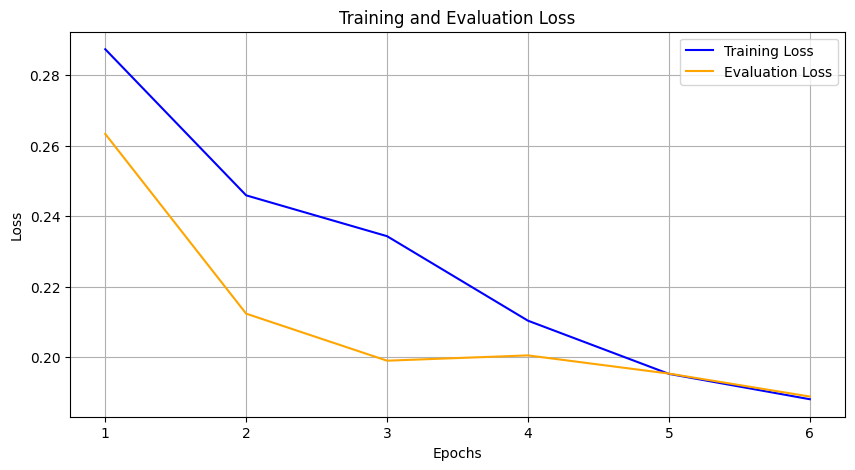

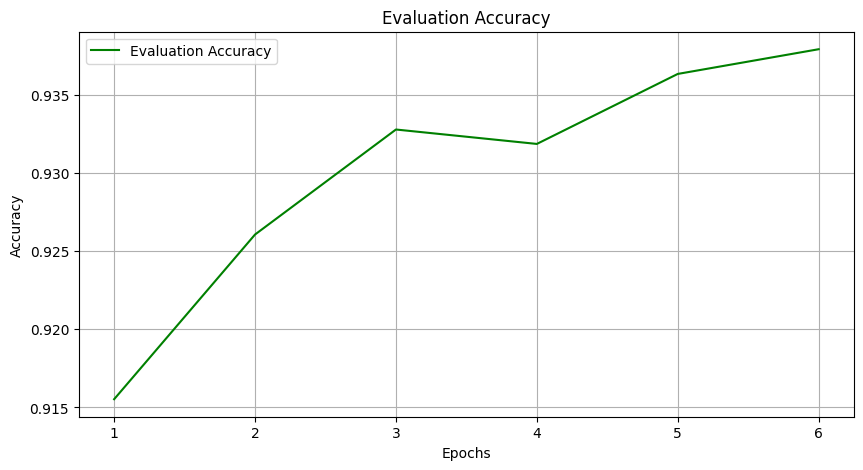

In [35]:
# Plotting the training loss and evaluation loss
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Extracting the training loss and evaluation loss from the trainer
# train_loss = trainer.state.log_history[0]['loss']
# eval_loss = trainer.state.log_history[0]['eval_loss']
# train_loss_values = [log['loss'] for log in trainer.state.log_history if 'loss' in log]
# eval_loss_values = [log['eval_loss'] for log in trainer.state.log_history if 'eval_loss' in log]

train_loss_values = []
eval_loss_values = []
eval_acc_values = []


for i in range(len(trainer.state.log_history)):
    log = trainer.state.log_history[i]
    if 'eval_loss' in log:
        eval_loss_values.append(log['eval_loss'])
        eval_acc_values.append(log['eval_accuracy'])
        train_loss_values.append(trainer.state.log_history[i-1].get('loss'))

train_loss_values = train_loss_values[:-1]
eval_loss_values = eval_loss_values[:-1]
eval_acc_values = eval_acc_values[:-1]
epoch_numbers = range(1, len(train_loss_values) + 1)

# # Extracting the epoch numbers for the x-axis
# epoch_numbers = [log['epoch'] for log in trainer.state.log_history if 'epoch' in log]

# Plotting the training loss and evaluation loss
plt.figure(figsize=(10, 5))
plt.plot(epoch_numbers, train_loss_values, label='Training Loss', color='blue')
plt.plot(epoch_numbers, eval_loss_values, label='Evaluation Loss', color='orange')  
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Evaluation Loss')
plt.legend()
plt.grid()
plt.show()

# Plotting the evaluation accuracy
plt.figure(figsize=(10, 5))
plt.plot(epoch_numbers, eval_acc_values, label='Evaluation Accuracy', color='green')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Evaluation Accuracy')
plt.legend()
plt.grid()
plt.show()


In [ ]:
# Saving the model
# merged_model = model.merge_and_unload()  # Merge LoRA weights with the base model weights

# # Save the model
# if not os.path.exists(config['output_dir']):
#     os.makedirs(config['output_dir'])

# merged_model.save_pretrained(config['output_dir'])

### Generating submission on test file

In [26]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, EarlyStoppingCallback
from datasets import load_dataset, Dataset
from torch.utils.data import DataLoader
from peft import get_peft_model, LoraConfig, TaskType, PeftModel
from sklearn.metrics import accuracy_score, f1_score, precision_score
import numpy as np
import pandas as pd
import pickle
import os
import json

In [27]:
def generate_test_results(model):
    with open(test_data_path, 'rb') as f:
        test_data = pickle.load(f)

    test_dataset = Dataset.from_dict({"text": test_data["text"]})

    tokenizer = AutoTokenizer.from_pretrained(config['tokenizer_model_name'])
    def tokenize_function(examples, tokenizer):
        return tokenizer(examples['text'], truncation = config['truncation'], padding = config['padding'], max_length = config['max_length'])

    tokenized_test_dataset = test_dataset.map(lambda x: tokenize_function(x, tokenizer), batched = True)
    tokenized_test_dataset.set_format("torch", columns = ["input_ids", "attention_mask"])

    test_dataloader = DataLoader(tokenized_test_dataset, batch_size = config['eval_batch_size'], shuffle = False)

    model.eval()
    predictions = []

    with torch.no_grad():
         for batch in test_dataloader:
             batch = {k: v.to(config['device']) for k, v in batch.items()}
             outputs = model(**batch)
             preds = torch.argmax(outputs.logits, dim=-1)
             predictions.extend(preds.cpu().numpy()) 
    
    df = pd.DataFrame({
    "ID": list(range(len(predictions))),   # ID ✅
    "label": predictions
    })
    df.to_csv("submission.csv", index=False)
    print("✅ Batched predictions complete. Saved to submission.csv.")

In [28]:
# Load model

dirs = os.listdir(config['output_dir'])
print(dirs)
dirs = sorted(dirs, key = lambda x: int(x.split('-')[1]))
checkpoint = dirs[-1]
checkpoint_path = os.path.join(config['output_dir'], checkpoint)
trainer_state_json = os.path.join(checkpoint_path, 'trainer_state.json')
with open(trainer_state_json, 'r') as f:
    trainer_state = json.load(f)

best_model_checkpoint = trainer_state['best_model_checkpoint']
print("Best model checkpoint:", best_model_checkpoint)



model = AutoModelForSequenceClassification.from_pretrained(config['model_name'], num_labels = config['num_labels'])
m = PeftModel.from_pretrained(model, best_model_checkpoint)
m = m.merge_and_unload()
m.to(config['device'])
generate_test_results(m)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


['checkpoint-11250', 'checkpoint-15000', 'checkpoint-18750', 'checkpoint-22500', 'checkpoint-3750', 'checkpoint-7500']
Best model checkpoint: ./model/best-model\checkpoint-22500


Map: 100%|██████████| 8000/8000 [00:00<00:00, 17377.70 examples/s]


✅ Batched predictions complete. Saved to submission.csv.


In [ ]:
# Compare two csv files and print the differences

def compare_csv(file1, file2):
    df1 = pd.read_csv(file1)
    df2 = pd.read_csv(file2)

    # Check if the two DataFrames are equal
    if df1.equals(df2):
        print("The two CSV files are identical.")
    else:
        print("The two CSV files are different.")
        # Find the differences
        diff = pd.concat([df1, df2]).drop_duplicates(keep=False)
        print(diff)


# Compare the two CSV files
compare_csv("submission.csv", "submission-v71.csv")